In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
"""
Es muy importante contar con los siguientes módulos:
"""
import models  #Módulo con los modelos de redes
import utils   #Módulo con funciones útiles para el proyecto

Final2


# Creación de datasets de entrenamiento, validación y testeo

Se tienen datos de 36 sujetos distintos. Estos se dividirán en conjuntos de entrenamiento, validación y testeo con 28, 5 y 3 sujetos respectivamente elegidos de manera aleatoria. Hay sujetos distintos entre los conjuntos porque el objetivo es lograr clasificar las señales de nuevos sujetos.

In [2]:
#Esta función divide los sujetos en entrenamiento y validación de forma aleatoria
path_files = 'EMG_data_for_gestures-master'
train_subjects, val_subjects, test_subjects  = utils.divide_Subjects(path_files = path_files, nval = 5, ntest = 3)
print("Train subjects: ", train_subjects)
print("Val subjects: ", val_subjects)
print("Test subjects: ", test_subjects)

Train subjects:  ['01', '02', '03', '04', '05', '07', '08', '09', '11', '12', '13', '14', '15', '17', '18', '19', '20', '22', '24', '26', '27', '28', '29', '30', '31', '32', '34', '36']
Val subjects:  ['21', '06', '25', '23', '35']
Test subjects:  ['33', '10', '16']


In [75]:
# Esta celda (escogiendo siempre a los mismos sujetos para entrenamiento, validación y prueba) se tiene solamente para fines de debuggeo
train_subjects =   ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '14', '15', '17', '19', '20', '21', '22', '24', '25', '26', '27', '28', '29', '31', '32', '34', '35']
val_subjects =  ['30', '36', '16', '18', '07']
test_subjects =  ['03', '33', '23']

# Modelo y entrenamiento

___
Revisar los módulos utils.py y models.py para más detalles de las funciones y de los modelos de usados respectivamente
___

In [4]:
# Esta función usa MinMaxScaler() sobre los datos de entrenamiento para poder normalizar posteriormente los datos
scaler = utils.get_scaler(train_subjects, path_files = path_files)

In [5]:
df_Train = utils.Windows_df_from_subjects(train_subjects, path_files = path_files, wait_size = 120, interleaved = (2,4), scaler=scaler)
df_Val = utils.Windows_df_from_subjects(val_subjects, path_files = path_files, wait_size = 120, scaler=scaler)
df_Test = utils.Windows_df_from_subjects(test_subjects, path_files = path_files, wait_size = 800, scaler=scaler)
print('Len df_Train with augment by inserts: ', len(df_Train))
print('Len df_Val : ', len(df_Val))
print('Len df_Test : ', len(df_Test))

Len df_Train with augment by inserts:  9286
Len df_Val :  1434
Len df_Test :  132


In [6]:
# En esta celda se aplica el aumento de datos por ruido gaussiano
# Este aumento se implementa en 'utils.GN_DataAugmentation()'
SNR = 35
N_Augmentation = 15
DF_TRAIN = [df_Train]

for j in range(N_Augmentation):
    DF_TRAIN.append(utils.GN_DataAugmentation(df_Train, SNR))    
DF_TRAIN = pd.concat(DF_TRAIN)
DF_TRAIN.reset_index(inplace=True, drop=True)

In [7]:
# Datset (de pytorch) se encuentra definido en utils.py
# Así, la creación de los dataloaders para la red funciona como sigue:
BATCH_SIZE = 64

ds_train = utils.Dataset_EMG(DF_TRAIN)
ds_val = utils.Dataset_EMG(df_Val)
ds_test = utils.Dataset_EMG(df_Test)

train_loader = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)  

In [8]:
# Definición de hiperparámetros y de modelo

LR = 0.035
EPOCHS = 100
PATIENCE=20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.EMG2DClassifier_V0(dropout = 0.15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [12]:
DF_TRAIN

,Window,Class
0,"[[[0.4980392156862745, 0.5019607843137255, 0.4...",0
1,"[[[0.4980392156862745, 0.49019607843137253, 0....",0
2,"[[[0.5058823529411764, 0.5058823529411764, 0.4...",0
3,"[[[0.5019607843137255, 0.5019607843137255, 0.4...",0
4,"[[[0.49019607843137253, 0.4784313725490196, 0....",0
...,...,...
148571,"[[[0.35429962290594297, 0.3595512515367868, 0....",5
148572,"[[[0.3204141380881278, 0.26063277383979533, 0....",5
148573,"[[[0.171935032670323, 0.3123626928742391, 0.48...",5
148574,"[[[0.33263386505846665, 0.39009611905633873, 0...",5


In [13]:
# Para entrenar los modelos se implementa la función 'utils.train()
# Si save != 0: guardará el estado del modelo que reporte el mejor resultado en validación en un archivo 'Best_model_i.pt'

metrics = utils.train(model, optimizer, criterion, train_loader, val_loader, EPOCHS, device,patience=PATIENCE, save = 1)


# metrics es un arreglo de la forma: (train_accs, train_losses, val_accs, val_losses, time)
# train_accs: accuaracies por época en set de entrenamiento
# train_losses: losses por época en set de entrenamiento
# val_accs: accuaracies por época en set de validación
# val_losses: losses por época en set de entrenamiento
# time: tiempo total de entrenamiento

Epochs  :  33%|███▎      | 33/100 [47:50<1:37:08, 86.99s/it]

Early Stopping at epoch 33


In [76]:
model = models.EMG2DClassifier_V0().to(device)
checkpoint = torch.load("Best_model_V0.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [86]:
# Ahora se genera el dataframe de predicciones vs la clase real
# utils.predictions_to_DF(model, data_loader,device) evalúa el modelo 'model' en 'device' con el 'data_loader'
# y genera un dataframe con las columnas "True Classes" y "Predicted Classes", las que representan exactamente lo que sus nombres indican

preds_Test = utils.predictions_to_DF(model, test_loader, device)

print('Test Accuracy : ', len(preds_Test[preds_Test["True Classes"]==preds_Test["Predicted Classes"]])/len(preds_Test))



Predicting  :: 100%|██████████| 3/3 [00:00<00:00, 37.10it/s]

Test Accuracy :  0.9090909090909091


[Text(0.5, 1.0, 'Confusion matrix in Testing'),
 Text(0.5, 42.0, 'Predicted Label'),
 Text(69.0, 0.5, 'True Lable')]

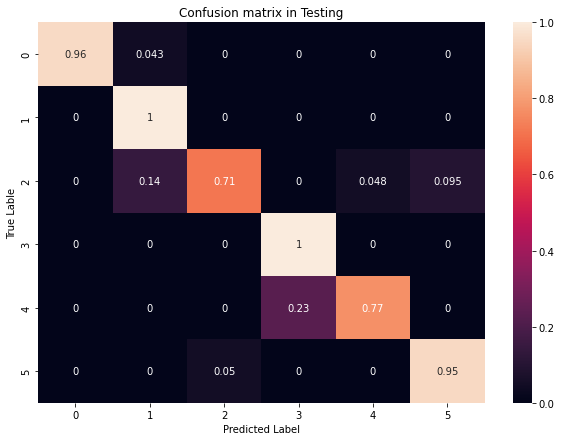

In [74]:
# Matriz de confusión en dataset de validación
cm = confusion_matrix(list(preds_Test["True Classes"]), list(preds_Test["Predicted Classes"]), normalize ='true')
plt.figure(figsize = (10,7))
s = sns.heatmap(cm, annot=True)

s.set(title = 'Confusion matrix in Testing'
      , xlabel='Predicted Label', ylabel='True Lable')